In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Mean-Variance Investing

* How should we allocate capital?

* You learn that very much depends on your preferences
    * What do you want to do with the money and when?
    * how terrible you feel if you have less than you expected
    * how much joy would you enjoy if you had more
    * depends on your risk-aversion, but also on lots of assumptions about you actually care about

* Under some assumptions about our preferences it comes down to a mean-variance criteria where you want to maximize the expected value  of your wealth at some future date (say when you retire) with a penalty for it's variance

* this can be written as maximizing the returns of your portfolio


$$ \max_X E[X'R_T]-a Var(X'R_T)$$


* where we typically call this $a$ parameter risk-aversion, because it captures how much you dislike that your wealth will move in unpredictable ways

* A similar criteria shows up in delegate asset management

* in hedge funds, manager get allocated some capital $W_0$ and some volatility budget $Vmax$, and are compensated by their absolute performance 

* so their problem is something like


$$ \max_X E[X'R_T]~~~subject~~to~~~Var(X'R_T)\leq Vmax $$






* thus lots of investment problems are versions of mean-variance 

* often these investment problems have a variety of additional constraints

    * concentration limits by industry
    * leverage limits
    * shorting constraints
    * etc

* Hard part is not solving the problem--that is easy!

* We will show how to do that numerically and analytically 

* Numerical solution will alow for a variety of constraints

* Analytical solution cannot deal with constraints and assumes free borrowing and lending at the risk-free rate

* Numerical solution is nice because it allow us to see clearly what this problem is all about.

**The hard problem is knowing the Expected returns of the assets and their covariance matrix**




## A bond-equity strategic investment problem of an international investor


* we will assume here that the risk-premium is being generated from a constant distribution

* this is wrong, but for large well diversified portfolio not too bad

* under this assumption, our estimation problem amounts to using sample means

* ths risk-free rate is time-varying so we will have to deal with it


We start by loading out return data

In [2]:
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
# the assets are the risk-free rate, the us equity market, the us bond market, the emerging market, the global equity market (without US), and the global bond market (without US)

Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Data.tail()

,RF,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,,
2016-08-31,0.0002,0.0052,-0.008417,0.025186,0.000838,-0.009552
2016-09-30,0.0002,0.0027,-0.016417,0.013153,0.012736,0.009979
2016-10-31,0.0002,-0.0200,-0.049460,0.002474,-0.020383,-0.043476
2016-11-30,0.0001,0.0487,-0.081636,-0.045971,-0.019798,-0.050359
2016-12-31,0.0003,0.0185,-0.005296,0.002904,0.034383,-0.023207


In [3]:
# we start by constructing excess returns by subtracting the risk-free rate from the returns of the assets and we drop the risk-free rate column
Re=Data.subtract(Data['RF'],axis=0).drop(['RF'],axis=1)

# we compute the mean and covariance matrix of the excess returns
ERe=Re.mean()
print(ERe)
Cove=Re.cov()
print(Cove)



MKTUS      0.005140
BondUS     0.002523
EM         0.006923
MKTxUS     0.004149
BondxUS    0.002054
dtype: float64
            MKTUS    BondUS        EM    MKTxUS   BondxUS
MKTUS    0.001948  0.000111  0.001292  0.001264  0.000187
BondUS   0.000111  0.001227 -0.000204 -0.000013  0.000264
EM       0.001292 -0.000204  0.003556  0.001661  0.000249
MKTxUS   0.001264 -0.000013  0.001661  0.002182  0.000422
BondxUS  0.000187  0.000264  0.000249  0.000422  0.000407


Suppose I want to reconstruct my current estimates of Expected returns and the covariance matrix of returns ( and not excess returns), What do I do?

Simply add the current risk-free rate to you estimate of the expected return

In [4]:
# set the risk-free rate to the current value of the 3-month T-bill rate divided by 12 to make it a monthly rate
rf=0.0525/12
# add to our estimate of risk-premiumns to get our estimate of expected returns

ER=ERe+rf

What about the covariance piece?

## Numerical solution

Lets start by solving

$ \max_X E[X'R_T]$ subject to $Var(X'R_T)\leq Vmax$

In [18]:
# STEP 1: define the fucntion that computes the portfolio variance and expected returns given a vector of weights X (initially set to equal weights)

def portfolio_variance(X=np.ones(5)/5):
    return X @ Cove @ X

def portfolio_expected_return(X=np.ones(5)/5):
     return X @ ER

print(portfolio_variance())
print(portfolio_variance(np.array([0.5,0.5,0,0,0])))

print(portfolio_expected_return())
print(portfolio_expected_return(np.array([0.5,0.5,0,0,0])))

0.0007914039297139135
0.0008490361488465391
0.008532889760767246
0.00820649669319938


In [19]:
# STEP 2: define the constraint functions, 

# here we will have one inequality for the portfolio variance , lets say a volatility of 10% per year. How do we translate this into a monthly variance?

# and one equality constraint for the weights to sum to one



Vmax=(0.2**2/12)
cons= ({'type': 'ineq',
          'fun' : lambda X: -portfolio_variance(X)+Vmax},
          {'type': 'eq',
          'fun' : lambda X: np.sum(X)-1})

# the constraint is normalized so that

#cons=({'type': 'ineq',
#          'fun' : lambda X: F(X)})

#means F(X)>=0

* Finally we are ready to do our minimization
* `options={'disp': True}`: tell python to report intermediary steps so we can check if the algorithm is doing progress towards a solution.
* There is a variety of additional parameters that you can pass to the minimizer. 
* see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html


In [20]:
# STEP 3: solve the minimization problem with constraints and save as `sol`
from scipy.optimize import minimize
X0=np.ones(5)/5
sol = minimize(lambda X: -portfolio_expected_return(X),X0, constraints=cons, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011929088527573371
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


In [21]:
#optimal weights
print(sol.x)
# optimal expected return at the annual frequency
print(portfolio_expected_return(sol.x)*12)
# optimal portfolio volatility at the annual frequenc
(portfolio_variance(sol.x)*12)**0.5

[ 0.65116149  0.38641724  0.83880728 -0.36993912 -0.50644688]
0.14314906233088046


0.20000201016577546

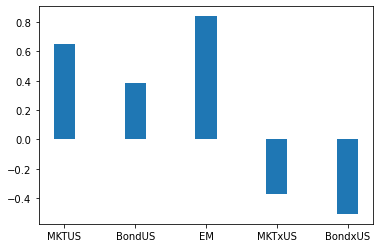

In [22]:
# below I am plotting the solution weights.
width=0.3
fig, ax = plt.subplots()
index=np.arange(sol.x.shape[0])

ax.bar(index,sol.x,width)

ax.set_xticks(index)
ax.set_xticklabels(ER.index)
plt.show()

Here we assumed the portfolio has to be fully invested in risky assets.

There is no leverage (borrowing at the risk-free rate)

but there is shorting (raising additional funds by selling one asset)

Note that is X0+X1=1, if X0<0, then X1>1

 



## Introducing a benchmark

* in mutual funds there is often a benchmark, say the S&P 500 and the manager has a mandate to have a tracking error relative to the benchmark that is low enough, say $Tmax$

* and the manager is compensated only with respect to the returns above this benchmark

* tracking error is the volatility of the portfolio relative to the benchmark: $\sqrt{var(X'R_T-R^{benchmark}_T)}$

The manager problem is ro maximize benchmark adjusted returns subject to some tracking error constraint

$ \max_X E[X'R_T-R^{benchmark}_T]$ subject to $Var(X'R_T-R^{benchmark}_T)\leq Tmax$


Assuming benchmark is in set of traded assets, you car write 

$ \max_X E[X'R_T-1_b'R_T]$ subject to $Var(X'R_T-1_b'R_T)\leq Tmax$

Which can be written as


$ \max_X E[(X-1_b)'R_T]$ subject to $(X-1_b)'Var(R_T)(X-1_b)\leq Tmax$

In [23]:

def portfolio_variance(X=np.ones(5)/5,Xbenchmark=np.array([0,0,0,0,0])):
    return (X -Xbenchmark)@ Cove @ (X-Xbenchmark)

def portfolio_expected_return(X=np.ones(5)/5,Xbenchmark=np.array([0,0,0,0,0])):
     return (X-Xbenchmark) @ ER


Xb=np.array([1,0,0,0,0])
Vmax=(0.2**2/12)
cons= ({'type': 'ineq',
          'fun' : lambda X: -portfolio_variance(X,Xbenchmark=Xb)+Vmax},
          {'type': 'eq',
          'fun' : lambda X: np.sum(X)-1})

X0=np.ones(5)/5
solb = minimize(lambda X: -portfolio_expected_return(X,Xbenchmark=Xb),X0, constraints=cons, options={'disp': True})


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.005220575391068462
            Iterations: 15
            Function evaluations: 90
            Gradient evaluations: 15


In [25]:
print(Cove.index)
#optimal weights no benchmark
print(sol.x)
#optimal weights with benchmark
print(solb.x)



Index(['MKTUS', 'BondUS', 'EM', 'MKTxUS', 'BondxUS'], dtype='object')
[ 0.65116149  0.38641724  0.83880728 -0.36993912 -0.50644688]
[ 1.71916096  0.06129325  0.73328686 -0.28549667 -1.2282444 ]


What happen here? Why the position in the market went up? Is that what you would expect?

In [ ]:
# optimal expected return at the annual frequency
print(portfolio_expected_return(solb.x)*12)
# portfolio volatility pf optimal portfolio at the annual frequency
print((portfolio_variance(solb.x)*12)**0.5)
#Trackign error
print((portfolio_variance(solb.x,Xbenchmark=Xb)*12)**0.5)
#Benchmark adjsuted returns
print((portfolio_expected_return(solb.x,Xbenchmark=Xb)*12))

## Information Ratio

Information ratio is how much you are expected to make in excess of the benchmark, divided by how much risk you are taking relative to the benchmark

$$InformationRatio=\frac{E[r_p-r_b]}{\sigma(r_p-r_p)}$$

In [ ]:
#The information ratio is the benchmark adjusted return divided by the tracking error
print((portfolio_expected_return(sol.x,Xbenchmark=Xb)*12)/(portfolio_variance(sol.x,Xbenchmark=Xb)*12)**0.5)

0.31322388844974003


Other things to do



Trace out how the optimal expected return varies as you change Vmax. In yearly volatility units try 6.5%, 7%, 8% , 10% ,15%,30%. Plot the resulting pairs in the scatter plot with the expected return in the y-axis and the volatility in the x-axis. What do you find?

Add the risk-free rate among the assets. There are different ways to do this. But a simple one is to change the expected return function  `X@ER+(1-np.sum(X))*rf`
* now X is the vector of risky assets only and (1-np.sum(X)) is whatever is the residual
* if this residual is positive you park in cash and earn rf
* if negative you borrow at the rf rate
* now your total weights mechanically add up to 1
* so you need to take out the equality constraint

Add a shorting constraint, say you can only short equities but not bonds, that is X>0 for certain assets

Add a leverage cap, so that the sum of your risky assets cannot exceed 1 too much, np.sum(X)-1 is called your leverage, so you can limit it to 1, so that for each dollar you have you borrow at most 1 dollar

Modify the expected return function to incorporate practical frictions in trading. For example, when you borrow you typically pay more than what you can invest at, there is a borrowing spread. Analogously if you short a stock, you have to pay an extra fee

## Analytical solution

The analytical solution assumes

- free borrowing and lending at risk-free rate
- Shorting without any shorting fees

The optimal weights are 

$$X=\sqrt{\frac{Vmax}{E[R^e]'Var(R^e)^{-1}E[R^e]}}Var(R^e)^{-1}E[R^e]$$

Where Vmax is in monthly variance units


Note that $\frac{Vmax}{E[R^e]'Var(R^e)^{-1}E[R^e]}$ is a number. Is basically a leverage factor. It leverage up (or down) the portfolio $Var(R^e)^{-1}E[R^e]$ so that the resulting portfolio has the desired target variance

This portfolio $Var(R^e)^{-1}E[R^e]$ is quite special because it has the highest Sharpe-ratio among all possible combinations of these assets





## Sharpe-ratio !

Sharpe ratio is probably the most used concept in money management, it comes in honor of William Sharpe ( the dude that discovered the CAPM). It reflects how much additional expected return you are getting per unit of volatility. Say you have a portfolio with expected returns $E[r_p]$

$$SharpeRatio=\frac{E[r_p]-rf}{\sigma(R_p)}$$


So a portfolio that has the highest sharpe ratio is nice because it is efficient. 

You take the minimum amount of risk that you need to take to achieve a expected return

or conversely you get the maximum possible expected return for a given level of risk that you are willing to take

_____

*Aside: Matrix inversion*

* You only need to understand how to operationaize it and in an conceptual level what it does

* But you don't need to follow all the mathematical details

* If you are interested. you can look in our linear algebra review in https://amoreira2.github.io/quantitativeinvesting/chapters/scientific/linear_algebra1.html

* I also provide a summary below

* Note that $(2)^{-1}=1/2=0.5$ (naturally!)

* $(Var(R^e))^{-1}$ is just like this 

* but more complicated because $Var(R^e)$ is a N by N matrix and we can't simply divide over to solve for X

* The definition of the inverse function is $f(x)=x^{-1}=y$ where $y*x=1$

* for matrices it is the same: $(Var(R^e))^{-1}Var(R^e)=I$, but now instead of 1, we have an identity matrix, which is a matrix with 1's in the diagonal and zero everywhere else


Thankfully we have a function in python that does just that




In [52]:
# start with a 2 by 2 matrix
a=np.array([[3,7],[0,9]])
print(a)

# compute the inverse
ainv=np.linalg.inv(a) 

ainv

[[3 7]
 [0 9]]


array([[ 0.33333333, -0.25925926],
       [ 0.        ,  0.11111111]])

In [53]:
# indeed ainv is the inverse of a because ainv @ a = I
ainv @ a

array([[1., 0.],
       [0., 1.]])

This portfolio is very special so it has many names

1. maximum sharpe ratio portfolio

2. mean-variance efficient portfolio (MVE)

3. Tangency portfolio

Names 1 and 2 are pretty clear. Name 3 will become clear later in the course

________________________
## **Finding the Mean-variance efficient portfolio**


First lets construct our vector of expected excess returns for our risky two assets US equity market and International equity market

In [64]:
assets=['MKTUS','MKTxUS']
e=ERe[assets]

e

MKTUS     0.005140
MKTxUS    0.004149
dtype: float64

We start by estimating the covariance matrix from our data $Var(R^e)$

In [65]:
c=Cove.loc[assets,assets]

c

,MKTUS,MKTxUS
MKTUS,0.001948,0.001264
MKTxUS,0.001264,0.002182


We then invert the covariance matrix $Var(R^e)^{-1}$

In [67]:
cinv=np.linalg.inv(c) 

cinv

array([[ 822.50792137, -476.49212708],
       [-476.49212708,  734.40580739]])

we then use the dot product to cross-mulitply our vector of expected excess returns by the inverse of the covariance matrix

$$Var(R^e)^{-1}E[R^e]$$

In [68]:
Wmve=cinv @ e
Wmve

array([2.25099751, 0.597729  ])

In [73]:
Vmax=(0.2**2/12)
Wmve * (Vmax/(e @cinv @ e))**0.5

array([0.53401107, 0.14180109])

Things to try


Verify that indeed the entire class of portfolios that solve the problem for different variance targets Vmax are also MVE ( i.e they all have the max sharpe ratio)

What is the allocation to the risk-free rate? How do you find it? How does it change as you increase/decrease Vmax?


How does max SR change as you go from 
1. only investing in the US equity market
1. investing in US equities and US bonds
1. Invest everywhere except emerging markets
1. investing everywhere including emerging markets
1. investing only in global equities and global bonds

Compare the gains of investing domestically ( US equities and bonds)  with investing internationally as well (US equities, US bonds, Global equities, global bonds).

Why the SR is going up ?What properties of the returns moments the mean-variance optimizer are exploiting? 

Do we think those are reliable properties? What is the alternative?

For the four investment opportunity sets above, compute the optimal expected returns for the following volatilities 6.5%, 7%, 8% , 10% ,15%,30%. Plot the results in a scatter plot with volatility in the X-axis and expected returns in the y-axis. You should see 5 lines. Why they look like that?

Compare the benefits of a US investor to invest globally and the benefit of an international investor investing in the US ( ignore Emerging markets). Looking at individual assets risk-premiums and volatility explain the benefits of investing across multiple assets